<a href="https://colab.research.google.com/github/nickwan/2025-sabersem-inspo/blob/main/2025_sabersem_rep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2025 sabersem replications  
thanks to the goat ssb

https://docs.google.com/document/d/165gr9wRmOJ8xcbSOSJjYir6COhB-zt2ytUh41M_kIlY/edit?pli=1&tab=t.0


In [ ]:
!pip install pybaseball
!pip install catboost

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
import os
import pybaseball as bb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import KFold, GroupKFold

project_dir = 'drive/My Drive/baseball/data'

<IPython.core.display.Javascript object>

In [ ]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-',ax=None):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  ax.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  ax.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  ax.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  ax.plot([-0.708, 0.708], [sz_top,sz_top], ls)

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective
  inputs:
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_hp(ls='k-', ax=None):
  """
  draw home plate
  draw home plate on a plot using mpl
  inputs:
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  ax.plot([0, -1.416666/2], [0,1.416666/2], ls)
  ax.plot([-1.416666/2,-1.416666/2], [1.416666/2,1.416666], ls)
  ax.plot([-1.416666/2,1.416666/2], [1.416666,1.416666], ls)
  ax.plot([1.416666/2,1.416666/2], [1.416666,1.416666/2], ls)
  ax.plot([1.416666/2,0], [1.416666/2,0], ls)

<IPython.core.display.Javascript object>

## path finder  
driveline squad  

In [ ]:
df = pd.read_csv(f'{project_dir}/2025-data.csv')
df.shape

<IPython.core.display.Javascript object>

(644076, 122)

In [ ]:
df['ball_bat_intercept_x'] = df['intercept_ball_minus_batter_pos_x_inches'].div(12)
df['ball_bat_intercept_y'] = df['intercept_ball_minus_batter_pos_y_inches'].div(12)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

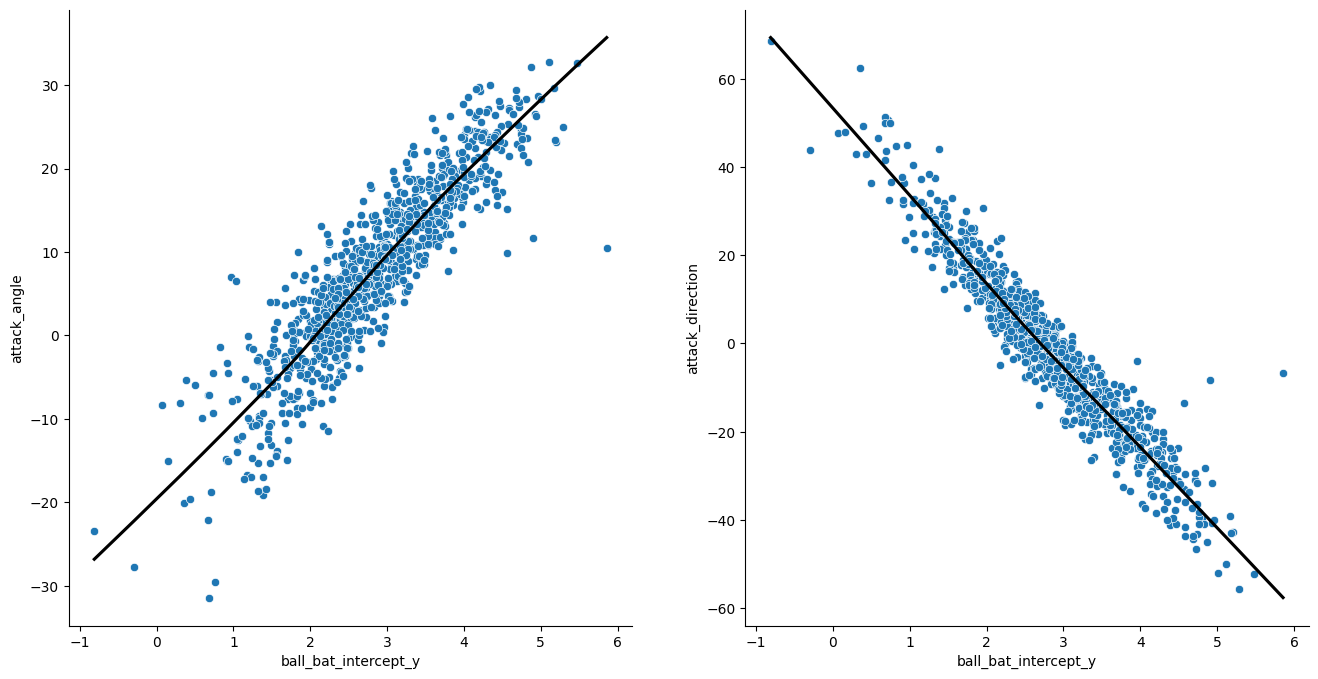

In [ ]:
# the slides do a ploy fit, i'm too lazy to do the quad so it's lowess here
pid = 673548
df_plt = df.loc[df['batter'] == pid]

x='ball_bat_intercept_y'
ys=['attack_angle', 'attack_direction']
fig, axes = plt.subplots(1,2,figsize=(16,8), sharex=True)
for idx, y in enumerate(ys):
  ax = axes[idx]
  sns.scatterplot(data=df_plt, x=x, y=y, ax=ax)
  sns.regplot(data=df_plt, x=x, y=y,color='k',lowess=True,scatter=False, ax=ax)
  sns.despine(ax=ax)
plt.show()

<IPython.core.display.Javascript object>

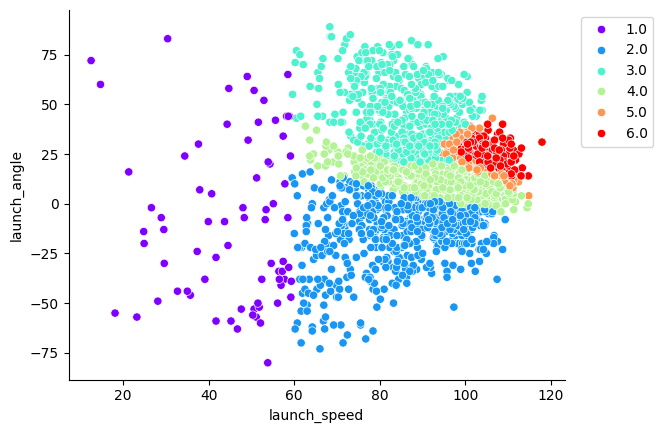

In [ ]:
# barrels in savant data is launch_speed_angle == 6 i believe
sns.scatterplot(data=df.sample(10000),x='launch_speed',
                y='launch_angle', hue='launch_speed_angle',
                palette='rainbow')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

In [ ]:
df['contact'] = 0
df['swstr'] = 0
df['barrel'] = 0
df['bip'] = 0
df['PA'] = 0

df.loc[df['bb_type'].notnull(), 'contact'] = 1
df.loc[df['description'].isin(['swinging_strike', 'swinging_strike_blocked']), 'swstr'] = 1
df.loc[df['description'].isin(['swinging_strike', 'swinging_strike_blocked']), 'swstr'] = 1
df.loc[df['launch_speed_angle']==6, 'barrel'] = 1
df.loc[df['description']=='hit_into_play', 'bip'] = 1
df.loc[df['events'].notnull(), 'PA'] = 1

<IPython.core.display.Javascript object>

In [ ]:
p = df['batter'].value_counts().to_frame().reset_index().rename(columns={'count':'P'})
df_agg = df.loc[:, ['batter', 'PA','bip', 'contact', 'swstr', 'barrel']].groupby(['batter'], as_index=False).sum()
df_agg = df_agg.merge(p, on='batter')

df_agg['barrel%'] = df_agg['barrel'].div(df_agg['contact'])
df_agg['swstr%'] = df_agg['swstr'].div(df_agg['P'])
df_agg['bip%'] = df_agg['bip'].div(df_agg['PA'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

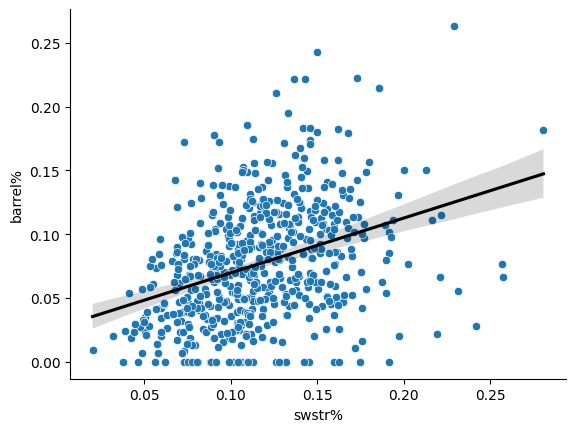

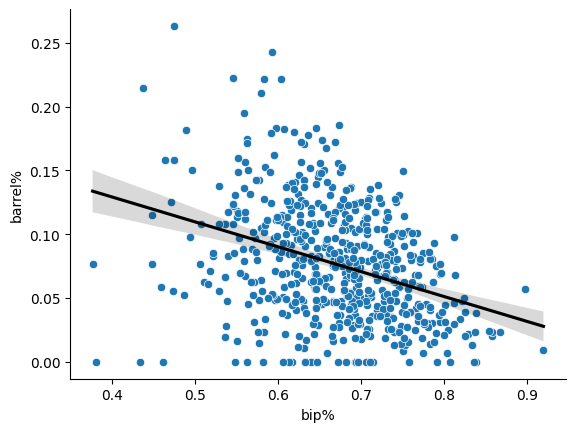

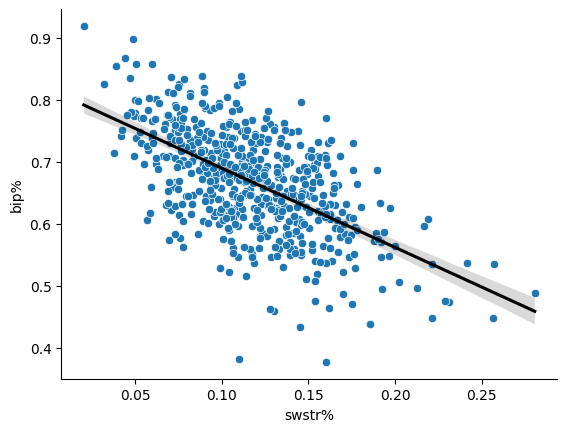

In [ ]:
# replicating the slide on BIP% and contact/power RV
# didn't have time to make a contact/power RV model
# used barrel rate and swstr rate as proxies -- similar arguments can be made
x='swstr%'
y='barrel%'
sns.scatterplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y)
sns.regplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, color='k', scatter=False)
sns.despine()
plt.show()

x='bip%'
y='barrel%'
sns.scatterplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y)
sns.regplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, color='k', scatter=False)
sns.despine()
plt.show()

x='swstr%'
y='bip%'
sns.scatterplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y)
sns.regplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, color='k', scatter=False)
sns.despine()
plt.show()


<IPython.core.display.Javascript object>

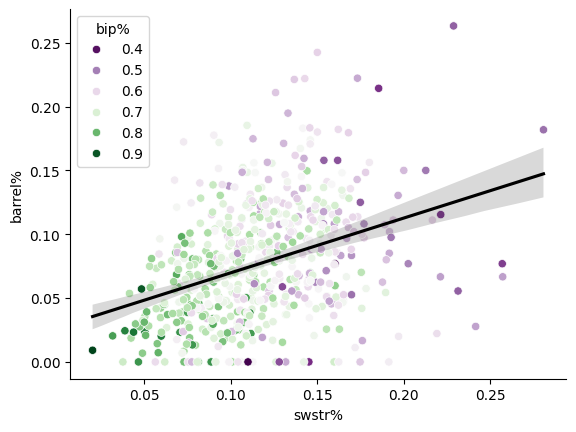

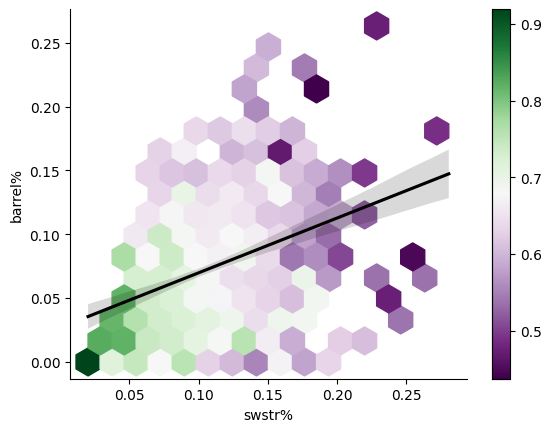

In [ ]:
# my opinion, could have made the argument with coloring by BIP% like below
x='swstr%'
y='barrel%'
hue='bip%'
sns.scatterplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, hue=hue,palette='PRGn')
sns.regplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, color='k', scatter=False)
sns.despine()
plt.show()

plt.hexbin(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, C=hue,cmap='PRGn',gridsize=15)
sns.regplot(data=df_agg.loc[df_agg['P']>=100], x=x, y=y, color='k', scatter=False)
plt.colorbar()
sns.despine()
plt.show()

In [ ]:
# this trig might be sus af
df['attack_direction_rad'] = np.deg2rad(df['attack_direction'])
df['swing_path_tilt_rad'] = np.deg2rad(df['swing_path_tilt'])

df['dir_x'] = np.cos(df['attack_direction_rad'])
df['dir_y'] = np.sin(df['attack_direction_rad'])
df['dir_z_attack'] = 0 # No vertical component from horizontal angle

df['tilt_y'] = np.cos(df['swing_path_tilt_rad'])
df['tilt_z'] = np.sin(df['swing_path_tilt_rad'])
df['tilt_x'] = 0 # No horizontal component from vertical angle

df['dir_xy_x'] = np.sin(df['attack_direction_rad']) # x component of horizontal direction
df['dir_xy_y'] = np.cos(df['attack_direction_rad']) # y component of horizontal direction

df['bat_dir_x'] = np.sin(df['attack_direction_rad']) * np.cos(df['swing_path_tilt_rad'])
df['bat_dir_y'] = np.cos(df['attack_direction_rad']) * np.cos(df['swing_path_tilt_rad'])
df['bat_dir_z'] = np.sin(df['swing_path_tilt_rad'])


for d in np.arange(-12, 49, 3):
  df[f'path_x_{d}'] = df['ball_bat_intercept_x'] + d * df['bat_dir_x']
  df[f'path_y_{d}'] = df['ball_bat_intercept_y'] + d * df['bat_dir_y']
  df[f'path_z_{d}'] = (df['plate_z']) + d * df['bat_dir_z'] # Need to get plate_z at intercept


<IPython.core.display.Javascript object>

In [ ]:
int_pts = [x for x in df.columns.values if 'path_x' in x] + [x for x in df.columns.values if 'path_y' in x] + [x for x in df.columns.values if 'path_z' in x]
feats = [
    'bat_speed', 'ball_bat_intercept_y', 'delta_run_exp'
]
df_agg = df.loc[:, ['batter']+feats+int_pts].groupby(['batter'],as_index=False).mean()
_df_agg = df.loc[:, ['batter','ball_bat_intercept_y']].groupby(['batter'],as_index=False).std().rename(columns={'ball_bat_intercept_y':'ball_bat_intercept_y_sd'})
_df_agg2 = df.loc[:, ['batter','PA','bip']].groupby(['batter'],as_index=False).sum()
df_agg = df_agg.merge(_df_agg, on='batter').merge(_df_agg2, on='batter')
df_agg['bip%'] = df_agg['bip'].div(df_agg['PA'])

df_agg = df_agg.loc[df_agg['PA']>20]
df_agg.shape

<IPython.core.display.Javascript object>

(604, 71)

<IPython.core.display.Javascript object>

/tmp/ipython-input-3781602308.py:29: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s,_s])


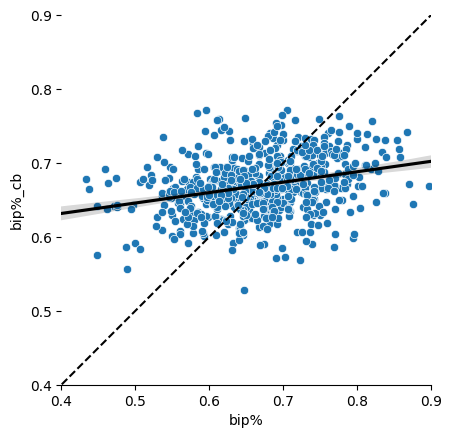

In [ ]:
feats = [
    'bat_speed', 'ball_bat_intercept_y',
    'path_x_-12', 'path_x_-9', 'path_x_-6', 'path_x_-3', 'path_x_0',
    'path_x_3', 'path_x_6', 'path_x_9', 'path_x_12', 'path_x_15',
    'path_x_18', 'path_x_21', 'path_x_24', 'path_x_27', 'path_x_30',
    'path_x_33', 'path_x_36', 'path_x_39', 'path_x_42', 'path_x_45',
    'path_x_48', 'path_y_-12', 'path_y_-9', 'path_y_-6', 'path_y_-3',
    'path_y_0', 'path_y_3', 'path_y_6', 'path_y_9', 'path_y_12',
    'path_y_15', 'path_y_18', 'path_y_21', 'path_y_24', 'path_y_27',
    'path_y_30', 'path_y_33', 'path_y_36', 'path_y_39', 'path_y_42',
    'path_y_45', 'path_y_48', 'path_z_-12', 'path_z_-9', 'path_z_-6',
    'path_z_-3', 'path_z_0', 'path_z_3', 'path_z_6', 'path_z_9',
    'path_z_12', 'path_z_15', 'path_z_18', 'path_z_21', 'path_z_24',
    'path_z_27', 'path_z_30', 'path_z_33', 'path_z_36', 'path_z_39',
    'path_z_42', 'path_z_45', 'path_z_48', 'ball_bat_intercept_y_sd'
]
target = 'bip%'

model_data = df_agg.dropna(subset=feats+[target])
s = pd.Series()
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  s = pd.concat([s,_s])
model_data[f'{target}_cb'] = s

sns.scatterplot(data=model_data, x=target, y=f'{target}_cb')
sns.regplot(data=model_data, x=target, y=f'{target}_cb', color='k',scatter=False)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.4,.9])
plt.ylim([0.4,.9])
sns.despine(left=True)
plt.gca().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>

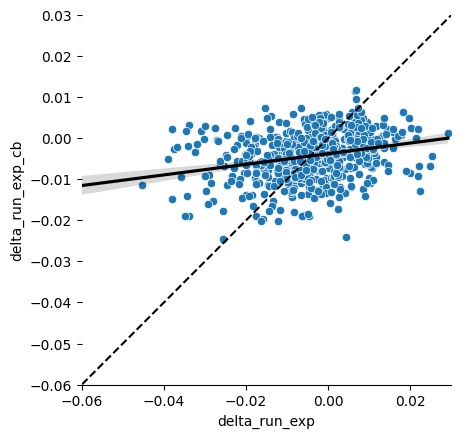

In [ ]:
feats = [
    'bat_speed', 'ball_bat_intercept_y',
    'path_x_-12', 'path_x_-9', 'path_x_-6', 'path_x_-3', 'path_x_0',
    'path_x_3', 'path_x_6', 'path_x_9', 'path_x_12', 'path_x_15',
    'path_x_18', 'path_x_21', 'path_x_24', 'path_x_27', 'path_x_30',
    'path_x_33', 'path_x_36', 'path_x_39', 'path_x_42', 'path_x_45',
    'path_x_48', 'path_y_-12', 'path_y_-9', 'path_y_-6', 'path_y_-3',
    'path_y_0', 'path_y_3', 'path_y_6', 'path_y_9', 'path_y_12',
    'path_y_15', 'path_y_18', 'path_y_21', 'path_y_24', 'path_y_27',
    'path_y_30', 'path_y_33', 'path_y_36', 'path_y_39', 'path_y_42',
    'path_y_45', 'path_y_48', 'path_z_-12', 'path_z_-9', 'path_z_-6',
    'path_z_-3', 'path_z_0', 'path_z_3', 'path_z_6', 'path_z_9',
    'path_z_12', 'path_z_15', 'path_z_18', 'path_z_21', 'path_z_24',
    'path_z_27', 'path_z_30', 'path_z_33', 'path_z_36', 'path_z_39',
    'path_z_42', 'path_z_45', 'path_z_48', 'ball_bat_intercept_y_sd'
]
target = 'delta_run_exp'

model_data = df_agg.dropna(subset=feats+[target])
s = pd.Series()
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  s = pd.concat([s,_s])
model_data[f'{target}_cb'] = s

sns.scatterplot(data=model_data, x=target, y=f'{target}_cb')
sns.regplot(data=model_data, x=target, y=f'{target}_cb', color='k',scatter=False)
plt.plot([-1,1], [-1,1], 'k--')
plt.xlim([-0.06,.03])
plt.ylim([-0.06,.03])
sns.despine(left=True)
plt.gca().set_aspect('equal')
plt.show()

replicated basically everything for the bip% model to pretty good replication. don't know what the data filtering was for the model -- also only using 2025 data (i think you can use 2024 as well to get larger sample). also the trig was AI and i didn't check it so probably wrong but it smelled kind of right?  

# swing process
ssb

In [ ]:
df = pd.read_csv(f'{project_dir}/2025-data.csv')
df['contact_depth'] = df['intercept_ball_minus_batter_pos_y_inches'].div(12)
df['pitch_type_code'] = df['pitch_type'].astype('category').cat.codes
df.shape

<IPython.core.display.Javascript object>

(644076, 123)

<IPython.core.display.Javascript object>

/tmp/ipython-input-2882929055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['contact_depth'] = df_plt['intercept_ball_minus_batter_pos_y_inches'].div(12)


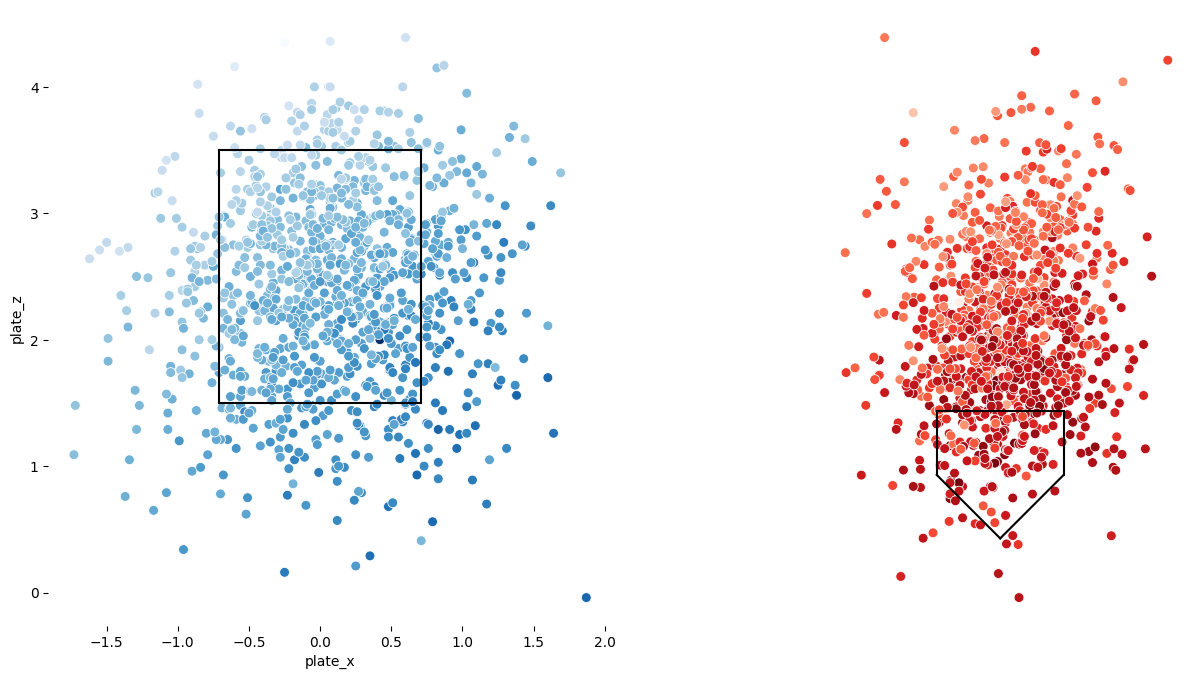

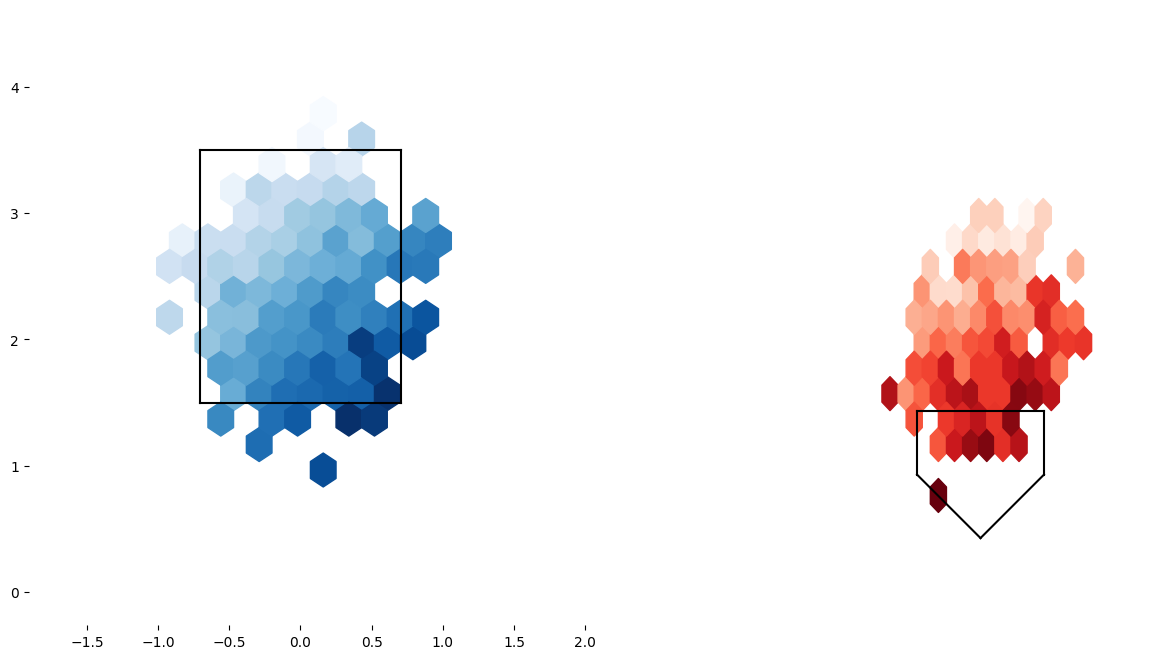

In [ ]:
bid = 660271
df_plt = df.loc[df['batter']==bid]
df_plt['contact_depth'] = df_plt['intercept_ball_minus_batter_pos_y_inches'].div(12)

fig,axes = plt.subplots(1,2,figsize=(16,8))

ax = axes[0]
sns.scatterplot(data=df_plt, x='plate_x', y='plate_z',
                hue='swing_path_tilt', palette='Blues',
                s=50, ax=ax)
sns.despine(left=True,bottom=True, ax=ax)
ax.legend().set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
draw_sz(ax=ax)
plt.gca().set_aspect('equal')

ax = axes[1]
sns.scatterplot(data=df_plt,x='plate_x',
                y='contact_depth', hue='release_speed',
                palette='Reds', s=50, ax=ax)
sns.despine(left=True,bottom=True, ax=ax)
ax.legend().set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
draw_hp(ax=ax)
plt.gca().set_aspect('equal')
plt.show()


fig,axes = plt.subplots(1,2,figsize=(16,8))
ax = axes[0]
ax.hexbin(data=df_plt, x='plate_x', y='plate_z',
           C='swing_path_tilt', cmap='Blues',
           gridsize=20, mincnt=5)
sns.despine(left=True,bottom=True,ax=ax)
ax.legend().set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
# fig.colorbar()
draw_sz(ax=ax)
plt.gca().set_aspect('equal')


ax = axes[1]
ax.hexbin(data=df_plt,x='plate_x',
                y='contact_depth', C='release_speed',
                cmap='Reds', gridsize=20, mincnt=5)
sns.despine(left=True,bottom=True,ax=ax)
ax.legend().set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
# fig.colorbar()
draw_hp(ax=ax)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
feats = [
    'swing_path_tilt', 'contact_depth'
]
target = 'pitch_type_code'
pred = pd.DataFrame()
kf = KFold(n_splits=3, shuffle=True)
model_data = df.dropna(subset=feats+[target])
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _pred = pd.DataFrame(model.predict_proba(test.loc[:, feats]), index=test.index)
  pred = pd.concat([pred,_pred])

pred = pred.add_suffix('_cb')
model_data = pd.concat([model_data, pred], axis=1)

<IPython.core.display.Javascript object>

In [ ]:
pt_map = model_data.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates().sort_values('pitch_type_code').set_index('pitch_type_code').to_dict()['pitch_type']
pred_cols = [x for x in model_data.columns.values if '_cb' in x]

<IPython.core.display.Javascript object>

In [ ]:
model_data['pitch_type_pred'] = model_data.loc[:, pred_cols].idxmax(axis=1)
model_data['pitch_type_pred'] = model_data['pitch_type_pred'].str[:-3].astype(int).map(pt_map)
model_data['swing_acc'] = 0
model_data.loc[model_data['pitch_type']==model_data['pitch_type_pred'], 'swing_acc'] = 1

<IPython.core.display.Javascript object>

In [ ]:
model_data['swing_acc'].describe()

<IPython.core.display.Javascript object>

,swing_acc
count,281347.000000
mean,0.314412
std,0.464282
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
x = model_data['batter'].value_counts()
bids = x[x>100].index.values
bests = model_data.loc[model_data['batter'].isin(bids), ['batter', 'swing_acc']].groupby('batter',as_index=False).mean().sort_values('swing_acc',ascending=False).head(10)
names = bb.playerid_reverse_lookup(bests['batter'].values)
names['batter_name'] = names['name_last'].add(', ').add(names['name_first'])
names = names.rename(columns={'key_mlbam':'batter'})
bests = names.loc[:, ['batter','batter_name']].merge(bests).sort_values('swing_acc',ascending=False)

<IPython.core.display.Javascript object>

In [ ]:
names.head()

<IPython.core.display.Javascript object>

,name_last,name_first,batter,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,batter_name
0,young,cole,702284,NaN,youngco01,-1,2025.0,2025.0,"young, cole"
1,veen,zac,691728,NaN,veenza01,-1,2025.0,2025.0,"veen, zac"
2,wisely,brett,689172,wiseb001,wiselbr01,27735,2023.0,2025.0,"wisely, brett"
3,collins,isaac,686555,colli001,colliis01,-1,2024.0,2025.0,"collins, isaac"
4,trammell,taylor,666211,tramt001,trammta01,19960,2021.0,2025.0,"trammell, taylor"


In [ ]:
fg = bb.batting_stats(start_season=2025,
                      end_season=2025, qual=0)

<IPython.core.display.Javascript object>

In [ ]:
fg.loc[fg['IDfg'].isin(names['key_fangraphs'].unique()), ['Name','xwOBA']].sort_values('xwOBA',ascending=False)

<IPython.core.display.Javascript object>

,Name,xwOBA
128,Mike Trout,0.362
283,Kody Clemens,0.341
292,Taylor Trammell,0.296
521,Jarred Kelenic,0.296
524,Nasim Nunez,0.277
410,Brett Wisely,0.275


In [ ]:
bests

<IPython.core.display.Javascript object>

,batter,batter_name,swing_acc
2,689172,"wisely, brett",0.487603
5,687515,"thomas, colby",0.477273
0,702284,"young, cole",0.472362
6,672284,"kelenic, jarred",0.451128
1,691728,"veen, zac",0.447619
4,666211,"trammell, taylor",0.446701
7,683083,"nuñez, nasim",0.446429
9,545361,"trout, mike",0.443337
8,665019,"clemens, kody",0.442142
3,686555,"collins, isaac",0.439706


# swing decisions
resnic  

In [ ]:
df = pd.read_csv(f'{project_dir}/2025-data.csv')
df['runner_on'] = df.loc[:, ['on_3b', 'on_2b', 'on_1b']].sum(axis=1).astype(bool).astype(int)

# create a column called attack_zone
df['attack_zone'] = 'waste'
df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.108, 1.108)) & (df['plate_z'].between(1.166,3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.666, 1.666)) & (df['plate_z'].between(0.5,4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

df['is_fb'] = 0
df['is_contact'] = 0
df['is_swing'] = 0

df.loc[df['pitch_type'].isin(['FF','SI','FA']), 'is_fb'] = 1
df.loc[df['description'].isin(['hit_into_play', 'foul']), 'is_contact'] = 1
df.loc[df['description'].isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked']), 'is_swing'] = 1

batter_cols = []

df_agg = df.loc[(df['is_contact']==1) & (df['attack_zone']!='waste'), ['batter', 'p_throws', 'is_fb', 'attack_zone', 'delta_run_exp']].groupby(['batter', 'p_throws', 'is_fb', 'attack_zone'], as_index=False).mean()
df_agg = pd.pivot_table(df_agg, index=['batter'], columns=['attack_zone', 'p_throws', 'is_fb'], values='delta_run_exp').reset_index()
df_agg.columns = df_agg.columns.to_flat_index()
df_agg.columns = [f"{x[0]}{x[1]}{x[2]}con" if 'batter' not in x[0] else x[0] for x in df_agg.columns.values]
for col in df_agg.columns.values:
  df_agg[col] = df_agg[col].fillna(df_agg[col].quantile(.25))

df = df.merge(df_agg, on='batter', how='left')
batter_cols.append([x for x in df_agg.columns.values if 'batter' not in x])

df_agg = df.loc[(df['is_swing']==1) & (df['attack_zone']!='waste'), ['batter', 'p_throws', 'is_fb', 'attack_zone', 'delta_run_exp']].groupby(['batter', 'p_throws', 'is_fb', 'attack_zone'], as_index=False).mean()
df_agg = pd.pivot_table(df_agg, index=['batter'], columns=['attack_zone', 'p_throws', 'is_fb'], values='delta_run_exp').reset_index()
df_agg.columns = df_agg.columns.to_flat_index()
df_agg.columns = [f"{x[0]}{x[1]}{x[2]}swing" if 'batter' not in x[0] else x[0] for x in df_agg.columns.values]
for col in df_agg.columns.values:
  df_agg[col] = df_agg[col].fillna(df_agg[col].quantile(.25))

df = df.merge(df_agg, on='batter', how='left')
batter_cols.append([x for x in df_agg.columns.values if 'batter' not in x])
df.shape

<IPython.core.display.Javascript object>

(644076, 122)

In [ ]:
feats = [
    'balls', 'strikes', 'is_fb', 'arm_angle'
] + batter_cols[0] + batter_cols[1]
target = 'delta_run_exp'

model_data = df.loc[df['runner_on']==0].dropna(subset=feats+[target])
s = pd.Series()
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  s = pd.concat([s,_s])

model_data[f'{target}_cb'] = s

<IPython.core.display.Javascript object>

/tmp/ipython-input-3974586932.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s,_s])


<IPython.core.display.Javascript object>

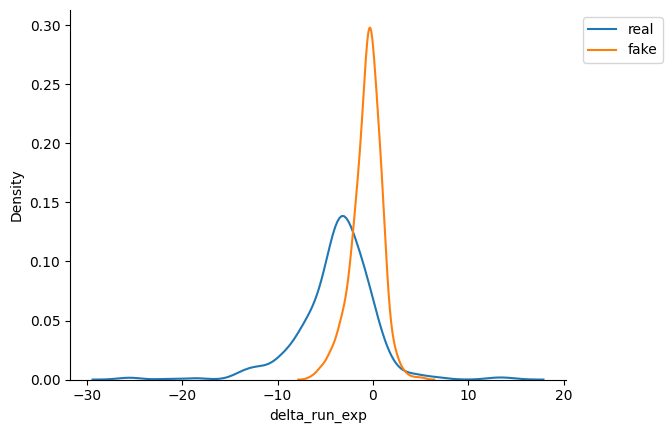

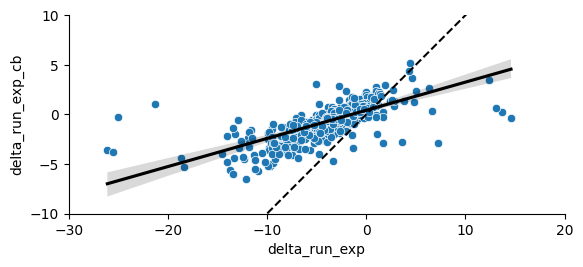

In [ ]:
df_plt = model_data.loc[model_data['is_swing']==1, ['batter',target,f'{target}_cb']].groupby(['batter'],as_index=False).mean()
df_plt[f'{target}_cb'] = df_plt[f'{target}_cb'].mul(100)
df_plt[target] = df_plt[target].mul(100)

sns.kdeplot(df_plt[target],label='real')
sns.kdeplot(df_plt[f"{target}_cb"],label='fake')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt, x=target, y=f'{target}_cb')
sns.regplot(data=df_plt, x=target, y=f'{target}_cb', color='k',scatter=False)
plt.plot([-100,100], [-100,100], 'k--')
plt.xlim([-30,20])
plt.ylim([-10,10])
sns.despine(left=True)
plt.gca().set_aspect('equal')
sns.despine()
plt.show()

# whiff factor
gabe applebaum  

In [ ]:
df = pd.read_csv(f'{project_dir}/2025-data.csv')
df['is_lhb'] = 0
df['is_lhp'] = 0
df['is_top_inning'] = 0
df['is_swing'] = 0

df.loc[df['stand']=='L', 'is_lhb'] = 1
df.loc[df['p_throws']=='L', 'is_lhp'] = 1
df.loc[df['inning_topbot']=='Top', 'is_top_inning'] = 1
df.loc[df['description'].isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked']), 'is_swing'] = 1

cols = ['on_3b', 'on_2b', 'on_1b']
for col in cols:
  df[f"is_{col}"] = df[col].astype(bool).astype(int)

df['venue'] = df['home_team'].astype('category').cat.codes
df['is_hr'] = 0
df.loc[df['events']=='home_run', 'is_hr'] = 1
df.shape

<IPython.core.display.Javascript object>

(644076, 131)

In [ ]:
feats = [
    'release_speed', 'release_pos_x','release_spin_rate', 'release_extension',
    'release_pos_z','spin_axis','pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'bat_speed', 'swing_length','arm_angle',
    'attack_angle', 'attack_direction', 'swing_path_tilt',
    'intercept_ball_minus_batter_pos_x_inches',
    'intercept_ball_minus_batter_pos_y_inches', 'spray_angle',
    'swing', 'launch_speed', 'launch_angle', 'is_lhb', 'is_lhp', 'venue'
]
target = "is_hr"
model_data = df.dropna(subset=['release_speed', 'release_pos_x','release_spin_rate', 'release_extension',
    'release_pos_z','spin_axis','pfx_x', 'pfx_z', 'plate_x', 'plate_z'])

s = pd.Series()
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict_proba(test.loc[:, feats])[:,1], index=test.index)
  s = pd.concat([s,_s])

model_data[f'{target}_with_venue'] = s

<IPython.core.display.Javascript object>

/tmp/ipython-input-3860028517.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s,_s])
/tmp/ipython-input-3860028517.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_with_venue'] = s


In [ ]:
model_data['venue_shuffle'] = model_data['venue'].sample(model_data['venue'].shape[0]).reset_index(drop=True)


<IPython.core.display.Javascript object>

/tmp/ipython-input-3058954593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['venue_shuffle'] = model_data['venue'].sample(model_data['venue'].shape[0]).reset_index(drop=True)


In [ ]:
model_data.loc[:, ['venue_shuffle', 'venue']].sample(20)

<IPython.core.display.Javascript object>

,venue_shuffle,venue
237903,29.0,3
216039,21.0,7
202551,22.0,22
78356,7.0,12
450484,2.0,3
336154,12.0,4
147346,12.0,24
19441,20.0,23
56847,9.0,6
24799,18.0,3


In [ ]:
feats = [
    'release_speed', 'release_pos_x','release_spin_rate', 'release_extension',
    'release_pos_z','spin_axis','pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'bat_speed', 'swing_length','arm_angle',
    'attack_angle', 'attack_direction', 'swing_path_tilt',
    'intercept_ball_minus_batter_pos_x_inches',
    'intercept_ball_minus_batter_pos_y_inches', 'spray_angle',
    'swing', 'launch_speed', 'launch_angle', 'is_lhb', 'is_lhp', 'venue_shuffle'
]
target = "is_hr"

s = pd.Series()
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(verbose=False, iterations=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict_proba(test.loc[:, feats])[:,1], index=test.index)
  s = pd.concat([s,_s])

model_data[f'{target}_without_venue'] = s

<IPython.core.display.Javascript object>

/tmp/ipython-input-2163818157.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s,_s])
/tmp/ipython-input-2163818157.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_without_venue'] = s


In [ ]:
vmap = df.loc[:, ['home_team', 'venue']].drop_duplicates()
df_hr = model_data.loc[:, ['venue', f'{target}_with_venue', f'{target}_without_venue']].groupby('venue',as_index=False).sum()
df_hr = vmap.merge(df_hr, on='venue')

<IPython.core.display.Javascript object>

In [ ]:
df_hr['diff'] = df_hr['is_hr_with_venue'].sub(df_hr['is_hr_without_venue'])

<IPython.core.display.Javascript object>

In [ ]:
df_hr.sort_values('diff', ascending=False)

<IPython.core.display.Javascript object>

,home_team,venue,is_hr_with_venue,is_hr_without_venue,diff
13,ATH,0,183.716622,152.647567,31.069055
26,TB,26,154.336082,132.730337,21.605745
12,LAD,14,198.599725,187.797247,10.802478
27,LAA,13,184.339728,174.248315,10.091413
4,CIN,6,156.379360,148.153521,8.225838
11,HOU,11,136.725682,131.355390,5.370292
0,PHI,20,166.523205,161.617528,4.905677
10,COL,8,173.716280,170.029878,3.686402
19,MIA,15,150.818343,147.468156,3.350187
17,MIL,16,125.299834,122.192631,3.107202


In [ ]:
df_hr.sort_values('diff', ascending=False)

<IPython.core.display.Javascript object>

,home_team,venue,is_hr_with_venue,is_hr_without_venue,diff
13,ATH,0,183.716622,150.988255,32.728367
26,TB,26,154.336082,135.342945,18.993136
15,BAL,3,185.933658,179.494529,6.439129
12,LAD,14,198.599725,192.899917,5.699808
27,LAA,13,184.339728,179.161179,5.178549
11,HOU,11,136.725682,131.784161,4.941521
4,CIN,6,156.379360,151.883277,4.496083
25,AZ,2,174.518797,170.087856,4.430941
7,CWS,9,187.965604,183.580680,4.384923
2,WSH,29,140.829072,137.097493,3.731579


# that's all for now :)

i retire on 10/29/2025